# This notebook aims to compare a few different model training approaches when it comes to age estimation problem.
* Proxyless Indexed tensor
  * Frozen backbone, only age head trained
  * Model trained entirely on age problem
* Proxyless aged tensor, dimension of 10
* Proxyless aged tensor, dimension of 30
* ResNet18 baseline model
  * Frozen backbone
  * Entirely trained

In [1]:
import albumentations as A
import albumentations.pytorch as Ap
import torch.nn.functional as F
from torch import cuda
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
import time
import math
import os
import cv2
import random
import PIL
import pandas
from os.path import join
import copy
import timm 
from collections import OrderedDict
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 
plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
#Data preprocessing for age training 
data_transforms = {
    'train': A.Compose([
        A.Resize(112, 112),
        A.RandomResizedCrop(height=112,width=112,scale=(0.5, 1.0)),

        A.core.composition.OneOf ([ 
            A.Blur(p=0.5),#Размытие входного изображения с помощью ядра случайного размера. 
            A.GaussianBlur(p=0.5),#Размытие входного изображения с помощью фильтра Гаусса со случайным размером ядра. 
            A.GaussNoise(p=0.5),#Примените гауссовский шум к входному изображению. 
            A.ISONoise(p=0.5),#Примените шум сенсора камеры. 
            A.MedianBlur(p=0.5),#Размытие входного изображения с помощью медианного фильтра со случайным линейным размером апертуры.
            A.MotionBlur(p=0.5),#Примените размытие движения к входному изображению, используя ядро случайного размера. 
            A.CLAHE(p=0.5),#Примените коррекцию адаптивной гистограммы с ограничением контраста к входному изображению.
            A.Equalize(p=0.5),#Выровняйте гистограмму изображения. 
        ], p = 1),

        A.core.composition.OneOf ([ 
            A.ChannelDropout(p=0.5),#Случайно отбросьте каналы во входном изображении.
            A.ChannelShuffle(p=0.5),#Произвольно переставьте каналы входного изображения RGB.
            A.InvertImg(p=0.5),#Инвертируйте входное изображение, вычитая значения пикселей из 255
            A.Solarize(p=0.5),#Инвертировать все значения пикселей выше порога. 
            A.ToGray(p=0.5),#Преобразуйте входное изображение RGB в оттенки серого.
            A.HueSaturationValue(p=0.5),#Произвольно изменяйте оттенок, насыщенность и значение входного изображения. 
            A.RandomBrightness(p=0.5),#Произвольно изменяйте яркость входного изображения. 
            A.RandomBrightnessContrast(p=0.5),#Произвольно изменяйте яркость и контраст входного изображения.
            A.RandomContrast(p=0.5)#Произвольно изменяйте контраст входного изображения.
        ], p = 1),
        A.core.composition.OneOf ([ 
           A.Downscale(scale_min=0.2, scale_max=0.2,p=0.5),#Уменьшает качество изображения за счет уменьшения и обратного увеличения. 
           A.Downscale(scale_min=0.3, scale_max=0.3,p=0.5),#Уменьшает качество изображения за счет уменьшения и обратного увеличения. 
           A.Downscale(scale_min=0.4, scale_max=0.4,p=0.5),#Уменьшает качество изображения за счет уменьшения и обратного увеличения. 
           A.Downscale(scale_min=0.5, scale_max=0.5,p=0.5),#Уменьшает качество изображения за счет уменьшения и обратного увеличения. 
           A.Downscale(scale_min=0.6, scale_max=0.6,p=0.5),#Уменьшает качество изображения за счет уменьшения и обратного увеличения. 
           A.Downscale(scale_min=0.7, scale_max=0.7,p=0.5),#Уменьшает качество изображения за счет уменьшения и обратного увеличения. 
           A.Downscale(scale_min=0.8, scale_max=0.8,p=0.5),#Уменьшает качество изображения за счет уменьшения и обратного увеличения. 
           A.Downscale(scale_min=0.9, scale_max=0.9,p=0.5),#Уменьшает качество изображения за счет уменьшения и обратного увеличения. 
           A.Downscale(scale_min=0.99, scale_max=0.99,p=0.5),#Уменьшает качество изображения за счет уменьшения и обратного увеличения. 
        ], p = 1),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        Ap.transforms.ToTensorV2()
        ]),
    'val': A.Compose([
        A.Resize(112, 112),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        Ap.transforms.ToTensorV2()
        ]),
}

from Datasets.age_data_pipeline import MyDataset_age,dataloader_age

data_dir = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_GordeevN/Over_dataset'
annotations = {'train':'anataishon_train.csv','val':'anataishon_val.csv'}
item_probabilities = {'train':'anataishon_train_rasp.txt','val':'anataishon_val_rasp.txt'}
image_datasets = {x: MyDataset_age(data_dir,annotations[x],list(range(1,91)),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: dataloader_age(image_datasets[x],data_dir,item_probabilities[x], batch_size=4,
                                             shuffle=False, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: image_datasets[x].__len__() for x in ['train', 'val']}
class_names = image_datasets['train'].classes



## Let's visualize train images to see how strong augmentations are

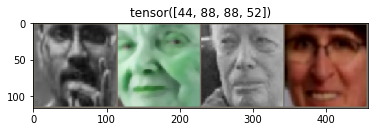

In [38]:
inputs,agr_range,classes = next(iter(dataloaders['train']))

imgs = torchvision.utils.make_grid(inputs)

imgs = imgs.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
imgs = std * imgs + mean
imgs = np.clip(imgs, 0, 1)

plt.imshow(imgs)
if classes is not None:
    plt.title(classes)
plt.pause(0.001) 

## First, we are going to test the approach when age-head has 30 output units representing probability of its own age range(1-3,..,87-90), then the probability vector is dot producted with the vector indexing each age group, then the result is considered to age estimation.

**As we have 2 different age representation at the end of the head (class units probs and regression predicts) we should use the loss function composed of crossentropy loss for age class units and L1 loss for regression pred**

In [16]:
#Train loop for age training 
def train_model(model, classification_criterion,regression_criterion, optimizer, scheduler, losses_ratio = None,num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            model.eval()   # Set model to evaluate mode

            running_class_loss = 0.0
            running_regress_loss = 0.0
            

            # Iterate over data.
            for inputs, class_labels,regress_labels in dataloaders[phase]:
                class_labels = class_labels.type(torch.FloatTensor)
                regress_labels = regress_labels.type(torch.FloatTensor)
                inputs = inputs.to(device)
                class_labels = class_labels.to(device)
                regress_labels = regress_labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    age_group,age_digit = model(inputs)[1]
                    batch_regression_loss = regression_criterion(age_digit, regress_labels)
                    batch_classification_loss = classification_criterion(age_group, class_labels.long())
                    
                    
                    if (losses_ratio == None):
                        if (batch_regression_loss > batch_classification_loss):
                            alpha = batch_regression_loss / batch_classification_loss
                            loss = alpha * batch_classification_loss + batch_regression_loss
                        else:
                            alpha = batch_classification_loss / batch_regression_loss
                            loss = batch_classification_loss +  alpha * batch_regression_loss
                    else:
                        loss = losses_ratio[0] * batch_regression_loss + losses_ratio[1] * batch_classification_loss
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_class_loss += batch_classification_loss.item() * inputs.size(0)
                running_regress_loss += batch_regression_loss.item() * inputs.size(0)
                
            if phase == 'train':
                scheduler.step()

            epoch_class_loss = running_class_loss / dataset_sizes[phase]
            epoch_regress_loss = running_regress_loss/ dataset_sizes[phase]
            avrg_epoch_loss = (epoch_class_loss+epoch_regress_loss)/2

            
            print('{} Classificatoin_Loss: {:.4f} Regression_Loss: {:.4f}'.format(
                phase, epoch_class_loss, epoch_regress_loss))

            # deep copy the model
            if phase == 'val' and avrg_epoch_loss < best_loss:
                best_loss = avrg_epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [76]:
from utils.MultiTaskModel_grouped_age_head_proxyless import MultiTaskModel_grouped_age_head
from utils.MultiTaskModel_proxyless import MultiTaskModel

model_proxyless_frozen_backbone = torch.hub.load('mit-han-lab/ProxylessNAS', "proxyless_cpu" , pretrained=True)
model_proxyless_frozen_backbone.classifier = nn.Sequential(*list(model_proxyless_frozen_backbone.classifier.children())[:-3])
model_proxyless_frozen_backbone = MultiTaskModel(model_proxyless_frozen_backbone)
model_proxyless_frozen_backbone.fc2 = nn.Linear(in_features=1432, out_features=1400, bias=True)
model_proxyless_frozen_backbone = MultiTaskModel_grouped_age_head(model_proxyless_frozen_backbone)
model_proxyless_frozen_backbone.load_state_dict(torch.load('/storage_labs/3030/BelyakovM/Face_attributes/Saved_models/proxyless-cpu_frozen_age_trained_3_heads.pth',map_location=device))
model_proxyless_frozen_backbone.to(device)

Using cache found in /root/.cache/torch/hub/mit-han-lab_ProxylessNAS_master


MultiTaskModel_grouped_age_head(
  (encoder): MultiTaskModel(
    (encoder): ProxylessNASNets(
      (first_conv): ConvLayer(
        (bn): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU6(inplace=True)
        (conv): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      )
      (blocks): ModuleList(
        (0): MobileInvertedResidualBlock(
          (mobile_inverted_conv): MBInvertedConvLayer(
            (depth_conv): Sequential(
              (conv): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (bn): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (relu): ReLU6(inplace=True)
            )
            (point_linear): Sequential(
              (conv): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_run

### Frozen the model backbone and verify it on 2 test images. Then trained the model and saw regression loss 

In [77]:
#freezing all the parameters and batchnorms except parameters of age and emotion heads
for module in model_proxyless_frozen_backbone.encoder.modules():
    if isinstance(module,nn.modules.BatchNorm1d):
        module.eval()
    if isinstance(module,nn.modules.BatchNorm2d):
        module.eval()
    if isinstance(module,nn.modules.BatchNorm3d):
        module.eval()
for i in model_proxyless_frozen_backbone.parameters():
    i.requires_grad = False
for param in model_proxyless_frozen_backbone.encoder.fc2.parameters():
    param.requires_grad = True
for k in model_proxyless_frozen_backbone.encoder.fc3.parameters():
    k.requires_grad = True
for k in model_proxyless_frozen_backbone.age_group_head.parameters():
    k.requires_grad = True
for name,param in model_proxyless_frozen_backbone.named_parameters():
    if param.requires_grad:
        print(name)
        

encoder.fc2.weight
encoder.fc2.bias
encoder.fc3.weight
encoder.fc3.bias
age_group_head.weight
age_group_head.bias


In [83]:
class_criterion = nn.CrossEntropyLoss()
regress_criterion = torch.nn.L1Loss()

optimizer_ft = optim.SGD(model_proxyless_frozen_backbone.parameters(), lr=0.0001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



model_proxyless_frozen_backbone = train_model(model_proxyless_frozen_backbone, class_criterion,regress_criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=150)

Epoch 0/149
----------
train Classificatoin_Loss: 4.6496 Regression_Loss: 12.4145
val Classificatoin_Loss: 4.7697 Regression_Loss: 10.2179

Epoch 1/149
----------
train Classificatoin_Loss: 4.5815 Regression_Loss: 12.5156
val Classificatoin_Loss: 4.6287 Regression_Loss: 10.4207

Epoch 2/149
----------
train Classificatoin_Loss: 4.5880 Regression_Loss: 12.3987
val Classificatoin_Loss: 4.9101 Regression_Loss: 10.9905

Epoch 3/149
----------
train Classificatoin_Loss: 4.6135 Regression_Loss: 12.5832
val Classificatoin_Loss: 4.6372 Regression_Loss: 10.3926

Epoch 4/149
----------
train Classificatoin_Loss: 4.6660 Regression_Loss: 12.4139
val Classificatoin_Loss: 4.9274 Regression_Loss: 10.4378

Epoch 5/149
----------
train Classificatoin_Loss: 4.6860 Regression_Loss: 12.5347
val Classificatoin_Loss: 4.6212 Regression_Loss: 10.1264

Epoch 6/149
----------
train Classificatoin_Loss: 4.6504 Regression_Loss: 12.2749
val Classificatoin_Loss: 4.6967 Regression_Loss: 10.5396

Epoch 7/149
--------

In [85]:
torch.save(model_proxyless_frozen_backbone.state_dict(),'/storage_labs/3030/BelyakovM/Face_attributes/Saved_models/proxyless-cpu_frozen_age_trained_3_heads.pth')

In [39]:
#Validating on 1st image that all the gender-trained parameters haven't changed 
tensor = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
pic = PIL.Image.open('/storage_labs/3030/BelyakovM/FaceMask_presence/ds/train/wo_mask/sibur/0/1_2020-07-10_19-18-18.jpg')
#pic = data_transforms['val'](image = pic)
pic = tensor(pic)
pic = pic.unsqueeze(0)
pic = pic.to(device)
model_proxyless_frozen_backbone.to(device)
outputs = model_proxyless_frozen_backbone(pic)
_, preds = torch.max(outputs[0], 1)

print(outputs[0])

tensor([[-0.1700,  0.4067]], device='cuda:1')


In [40]:
#Validating on 2nd image that all the gender-trained parameters haven't changed
tensor = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
pic = PIL.Image.open('/storage_labs/3030/BelyakovM/FaceMask_presence/ds/train/wo_mask/sibur/0/4853_2020-08-12_09-49-32.jpg')
pic = tensor(pic)
pic = pic.unsqueeze(0)
pic = pic.to(device)
model_proxyless_frozen_backbone.to(device)
outputs = model_proxyless_frozen_backbone(pic)
_, preds = torch.max(outputs[0], 1)

print(outputs[0])

tensor([[0.1195, 0.4292]], device='cuda:1')


### Let's compare frozen proxyless backbone with resnet18 frozen backbone whet it comes to only age-head training

In [16]:
#Only training of resnet18-baseline age-head 
from utils.MultiTaskModel_baseline import MultiTaskModel_baseline

model_resnet18_frozen_backbone = models.resnet18(pretrained = True)
model_resnet18_frozen_backbone.fc = nn.Sequential(*list(model_resnet18_frozen_backbone.fc.children())[:-3])
model_resnet18_frozen_backbone = MultiTaskModel_baseline(model_resnet18_frozen_backbone)

model_resnet18_frozen_backbone.to(device)

MultiTaskModel_baseline(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [17]:
for module in model_resnet18_frozen_backbone.encoder.modules():
    if isinstance(module,nn.modules.BatchNorm1d):
        module.eval()
    if isinstance(module,nn.modules.BatchNorm2d):
        module.eval()
    if isinstance(module,nn.modules.BatchNorm3d):
        module.eval()
for i in model_resnet18_frozen_backbone.parameters():
    i.requires_grad = False
for param in model_resnet18_frozen_backbone.fc2.parameters():
    param.requires_grad = True
for k in model_resnet18_frozen_backbone.fc3.parameters():
    k.requires_grad = True
for k in model_resnet18_frozen_backbone.age_group_head.parameters():
    k.requires_grad = True
for name,param in model_resnet18_frozen_backbone.named_parameters():
    if param.requires_grad:
        print(name)

fc2.weight
fc2.bias
fc3.weight
fc3.bias
age_group_head.weight
age_group_head.bias


In [18]:
class_criterion = nn.CrossEntropyLoss()
regress_criterion = torch.nn.L1Loss()

optimizer_ft = optim.SGD(model_resnet18_frozen_backbone.parameters(), lr=0.0001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_resnet18_frozen_backbone = train_model(model_resnet18_frozen_backbone, class_criterion,regress_criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=14)



Epoch 0/13
----------
train Classificatoin_Loss: 3.9286 Regression_Loss: 17.8083
val Classificatoin_Loss: 3.7560 Regression_Loss: 13.5887

Epoch 1/13
----------
train Classificatoin_Loss: 3.9904 Regression_Loss: 16.1013
val Classificatoin_Loss: 3.8600 Regression_Loss: 12.9088

Epoch 2/13
----------
train Classificatoin_Loss: 4.0240 Regression_Loss: 15.6662
val Classificatoin_Loss: 3.8370 Regression_Loss: 13.3476

Epoch 3/13
----------
train Classificatoin_Loss: 4.0975 Regression_Loss: 15.5192
val Classificatoin_Loss: 3.9120 Regression_Loss: 12.7324

Epoch 4/13
----------
train Classificatoin_Loss: 4.2055 Regression_Loss: 15.2444
val Classificatoin_Loss: 3.9437 Regression_Loss: 13.2061

Epoch 5/13
----------
train Classificatoin_Loss: 4.1960 Regression_Loss: 15.0251
val Classificatoin_Loss: 4.2497 Regression_Loss: 12.4198

Epoch 6/13
----------
train Classificatoin_Loss: 4.2517 Regression_Loss: 14.8936
val Classificatoin_Loss: 4.1818 Regression_Loss: 12.3079

Epoch 7/13
----------
train

### Seems like proxyless is able to predict age more precisely by 2 year on average 

### Next, we will see how accurate the models can predict age if trained entirely on age problem

In [25]:
from utils.MultiTaskModel_grouped_age_head_proxyless import MultiTaskModel_grouped_age_head
from utils.MultiTaskModel_proxyless import MultiTaskModel

model_proxyless_entirely_trained = torch.hub.load('mit-han-lab/ProxylessNAS', "proxyless_cpu" , pretrained=True)
model_proxyless_entirely_trained.classifier = nn.Sequential(*list(model_proxyless_entirely_trained.classifier.children())[:-3])
model_proxyless_entirely_trained = MultiTaskModel(model_proxyless_entirely_trained)

model_proxyless_entirely_trained.fc2 = nn.Linear(in_features=1432, out_features=1400, bias=True)
model_proxyless_entirely_trained = MultiTaskModel_grouped_age_head(model_proxyless_entirely_trained)
model_proxyless_entirely_trained.load_state_dict(torch.load('/storage_labs/3030/BelyakovM/Face_attributes/Saved_models/proxyless-cpu_age_trained_3_heads.pth',map_location=device))
model_proxyless_entirely_trained = model_proxyless_entirely_trained.to(device)

Using cache found in /root/.cache/torch/hub/mit-han-lab_ProxylessNAS_master


In [26]:
class_criterion = nn.CrossEntropyLoss()
regress_criterion = torch.nn.L1Loss()

optimizer_ft = optim.SGD(model_proxyless_entirely_trained.parameters(), lr=0.0001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_proxyless_entirely_trained = train_model(model_proxyless_entirely_trained, class_criterion,regress_criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Classificatoin_Loss: 3.0222 Regression_Loss: 6.6122
val Classificatoin_Loss: 2.9361 Regression_Loss: 6.9793

Epoch 1/14
----------
train Classificatoin_Loss: 3.0098 Regression_Loss: 6.5539
val Classificatoin_Loss: 3.1233 Regression_Loss: 7.2251

Epoch 2/14
----------
train Classificatoin_Loss: 3.0086 Regression_Loss: 6.4846
val Classificatoin_Loss: 2.9325 Regression_Loss: 6.5183

Epoch 3/14
----------
train Classificatoin_Loss: 2.9815 Regression_Loss: 6.4546
val Classificatoin_Loss: 2.9355 Regression_Loss: 7.0199

Epoch 4/14
----------
train Classificatoin_Loss: 2.9898 Regression_Loss: 6.4036
val Classificatoin_Loss: 2.9345 Regression_Loss: 6.6375

Epoch 5/14
----------
train Classificatoin_Loss: 3.0123 Regression_Loss: 6.5584
val Classificatoin_Loss: 3.0100 Regression_Loss: 6.9943

Epoch 6/14
----------
train Classificatoin_Loss: 3.0075 Regression_Loss: 6.3125
val Classificatoin_Loss: 3.0112 Regression_Loss: 7.0738

Epoch 7/14
----------
train Classificatoi

In [27]:
torch.save(model_proxyless_entirely_trained.state_dict(),'/storage_labs/3030/BelyakovM/Face_attributes/Saved_models/proxyless-cpu_age_trained_3_heads.pth')

In [13]:
#Training of resnet18-baseline entirely  
from utils.MultiTaskModel_baseline import MultiTaskModel_baseline

model_resnet18_entirely_trained = models.resnet18(pretrained = True)
model_resnet18_entirely_trained.fc = nn.Sequential(*list(model_resnet18_entirely_trained.fc.children())[:-3])
model_resnet18_entirely_trained = MultiTaskModel_baseline(model_resnet18_entirely_trained)

model_resnet18_entirely_trained.to(device)

MultiTaskModel_baseline(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [14]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
class_criterion = nn.CrossEntropyLoss()
regress_criterion = torch.nn.L1Loss()

optimizer_ft = optim.SGD(model_resnet18_entirely_trained.parameters(), lr=0.0001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_resnet18_entirely_trained = train_model(model_resnet18_entirely_trained, class_criterion,regress_criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Classificatoin_Loss: 3.9272 Regression_Loss: 18.2065
val Classificatoin_Loss: 3.6288 Regression_Loss: 11.1864

Epoch 1/14
----------
train Classificatoin_Loss: 3.7504 Regression_Loss: 12.2583
val Classificatoin_Loss: 3.4483 Regression_Loss: 9.0381

Epoch 2/14
----------
train Classificatoin_Loss: 3.7597 Regression_Loss: 10.5774
val Classificatoin_Loss: 3.5435 Regression_Loss: 8.3888

Epoch 3/14
----------
train Classificatoin_Loss: 3.8265 Regression_Loss: 9.7596
val Classificatoin_Loss: 3.4168 Regression_Loss: 8.8448

Epoch 4/14
----------
train Classificatoin_Loss: 3.8135 Regression_Loss: 9.2476
val Classificatoin_Loss: 3.3498 Regression_Loss: 8.1534

Epoch 5/14
----------
train Classificatoin_Loss: 3.7880 Regression_Loss: 8.9575
val Classificatoin_Loss: 3.5571 Regression_Loss: 7.9151

Epoch 6/14
----------
train Classificatoin_Loss: 3.8281 Regression_Loss: 8.4207
val Classificatoin_Loss: 3.4573 Regression_Loss: 7.7976

Epoch 7/14
----------
train Classificatoin_Loss: 3.9311 Reg

### Proxyless copes better by 1 year


### Further, we compute statistic for proxyless trained entirely and head-trained: for each age the most frequently confused ages, average confused age, mean deviation of gt-age and predicted age 

In [54]:
#Testing entirely trained proxyless on "over-dataset" val set
dsdir = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_GordeevN/Over_dataset/val'
path2save = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_GordeevN/Over_dataset/proxyless_confused/Entirely_trained'
model_proxyless_entirely_trained.load_state_dict(torch.load('/storage_labs/3030/BelyakovM/Face_attributes/Saved_models/proxyless-cpu_age_trained_3_heads.pth'))
transformations = transforms.Compose([
        transforms.Resize(112),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
net_predictions = [[] for i in range(1,91)]
count = 0

for age_gt in os.listdir(dsdir):
    for img_path in os.listdir(os.path.join(dsdir,age_gt)):
        count += 1
        img = default_loader(os.path.join(dsdir,age_gt,img_path))
        img = transformations(img)
        img = img.unsqueeze(0)
        img = img.to(device)
        _,age_pred = model_proxyless_entirely_trained(img)[1]
        #if age_gt[0] == '0': age_gt = age_gt.replace('0','')
        net_predictions[round(age_pred.item())-1].append(int(age_gt))
        if age_pred.item() < 9.5: 
            age_pred = '0'+ str(round(age_pred.item())) 
        else: 
            age_pred = str(round(age_pred.item()))
        img_pil = default_loader(os.path.join(dsdir,age_gt,img_path))
        img_pil = img_pil.save(os.path.join(path2save,age_pred,'gt-label:'+age_gt+'_pred:'+age_pred+'number:'+str(count)+'.jpg'))
        #print('Gt:'+age_gt+'pred:'+age_pred)


In [62]:
deviations = []
for arr in net_predictions:
    if arr:
        deviations.append()
        gt_count = {age: arr.count(age) for age in set(arr)}
        try:
            top_occurrence = sorted(gt_count,key = gt_count.get,reverse=True)[:4]
        except:
            top_occurrence = sorted(gt_count,key = gt_count.get,reverse=True)[:2]
        print('Top frequent ages in {0}:{1}. Average predicted age is {2},mean deviation is {3}'.format(net_predictions.index(arr)+1,top_occurrence,round(sum(top_occurrence)/len(top_occurrence),2),math.sqrt(sum(abs(net_predictions.index(arr)+1-int(gt))**2 for gt in top_occurrence)/len(top_occurrence))))
        deviations.append(math.sqrt(sum(abs(net_predictions.index(arr)+1-int(gt))**2 for gt in top_occurrence)/len(top_occurrence)))
print('Average deviation is {0}'.format(sum(deviations)/len(deviations)))

Top frequent ages in 1:[1, 2, 3, 4]. Average predicted age is 2.5,mean deviation is 1.8708286933869707
Top frequent ages in 2:[1, 2, 3, 4]. Average predicted age is 2.5,mean deviation is 1.224744871391589
Top frequent ages in 3:[1, 2, 3, 4]. Average predicted age is 2.5,mean deviation is 1.224744871391589
Top frequent ages in 4:[3, 4, 2, 5]. Average predicted age is 3.5,mean deviation is 1.224744871391589
Top frequent ages in 5:[2, 4, 3, 7]. Average predicted age is 4.0,mean deviation is 2.1213203435596424
Top frequent ages in 6:[5, 7, 6, 4]. Average predicted age is 5.5,mean deviation is 1.224744871391589
Top frequent ages in 7:[6, 4, 9, 2]. Average predicted age is 5.25,mean deviation is 3.122498999199199
Top frequent ages in 8:[8, 10, 4, 6]. Average predicted age is 7.0,mean deviation is 2.449489742783178
Top frequent ages in 9:[10, 8, 9, 5]. Average predicted age is 8.0,mean deviation is 2.1213203435596424
Top frequent ages in 10:[9, 10, 8, 2]. Average predicted age is 7.25,mean de

In [88]:
#Testing  proxyless frozen backbone on "over-dataset" val set

dsdir = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_GordeevN/Over_dataset/val'
path2save = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_GordeevN/Over_dataset/proxyless_confused/frozen_backbone'
model_proxyless_frozen_backbone.load_state_dict(torch.load('/storage_labs/3030/BelyakovM/Face_attributes/Saved_models/proxyless-cpu_frozen_age_trained_3_heads.pth'))
transformations = transforms.Compose([
        transforms.Resize(112),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
net_predictions = [[] for i in range(1,91)]
count = 0

for age_gt in os.listdir(dsdir):
    for img_path in os.listdir(os.path.join(dsdir,age_gt)):
        count += 1
        img = default_loader(os.path.join(dsdir,age_gt,img_path))
        img = transformations(img)
        img = img.unsqueeze(0)
        img = img.to(device)
        _,age_pred = model_proxyless_frozen_backbone(img)[1]
        #if age_gt[0] == '0': age_gt = age_gt.replace('0','')
        net_predictions[round(age_pred.item())-1].append(int(age_gt))
        if age_pred.item() < 9.5: 
            if round(age_pred.item()) < 1:
                age_pred = '01'
            else:
                age_pred = '0'+ str(round(age_pred.item())) 
        else: 
            age_pred = str(round(age_pred.item()))
        img_pil = default_loader(os.path.join(dsdir,age_gt,img_path))
        img_pil = img_pil.save(os.path.join(path2save,age_pred,'gt-label:'+age_gt+'_pred:'+age_pred+'number:'+str(count)+'.jpg'))
        #print('Gt:'+age_gt+'pred:'+age_pred)

In [91]:
deviations = []
for arr in net_predictions:
    if arr:
        #deviations.append()   
        gt_count = {age: arr.count(age) for age in set(arr)}
        try:
            top_occurrence = sorted(gt_count,key = gt_count.get,reverse=True)[:4]
        except:
            top_occurrence = sorted(gt_count,key = gt_count.get,reverse=True)[:2]
        print('Top frequent ages in {0}:{1}. Average predicted age is {2},mean deviation is {3}'.format(net_predictions.index(arr)+1,top_occurrence,round(sum(top_occurrence)/len(top_occurrence),2),math.sqrt(sum(abs(net_predictions.index(arr)+1-int(gt))**2 for gt in top_occurrence)/len(top_occurrence))))
        deviations.append(math.sqrt(sum(abs(net_predictions.index(arr)+1-int(gt))**2 for gt in top_occurrence)/len(top_occurrence)))
print('Average deviation is {0}'.format(sum(deviations)/len(deviations)))

Top frequent ages in 1:[1, 2, 3, 4]. Average predicted age is 2.5,mean deviation is 1.8708286933869707
Top frequent ages in 2:[1, 2, 3, 4]. Average predicted age is 2.5,mean deviation is 1.224744871391589
Top frequent ages in 3:[1, 2, 4, 3]. Average predicted age is 2.5,mean deviation is 1.224744871391589
Top frequent ages in 4:[1, 2, 3, 6]. Average predicted age is 3.0,mean deviation is 2.1213203435596424
Top frequent ages in 5:[2, 3, 1, 4]. Average predicted age is 2.5,mean deviation is 2.7386127875258306
Top frequent ages in 6:[2, 1, 6, 3]. Average predicted age is 3.0,mean deviation is 3.5355339059327378
Top frequent ages in 7:[7, 1, 2, 3]. Average predicted age is 3.25,mean deviation is 4.387482193696061
Top frequent ages in 8:[2, 6, 3, 7]. Average predicted age is 4.5,mean deviation is 4.06201920231798
Top frequent ages in 9:[4, 3, 5, 2]. Average predicted age is 3.5,mean deviation is 5.612486080160912
Top frequent ages in 10:[3, 8, 4, 5]. Average predicted age is 5.0,mean deviat

### Proxyless trained entirely predicts far more precisely then one with frozen backbone. At least by 5 year


## Here starts modeified approach training section.
## First, let's weaken the augmentations, and change our regression vector: reduce output units to 10 representing following age ranges  ['1-2', '3-6', '7-12', '13-17', '18-22', '23-26', '27-33', '34-44', '45-59', '60-90'], the mean age tensor is as follows [1.5, 4.5, 9.5, 15, 20, 24.5, 30, 39, 52, 75]. The main idea behind the vector is to make each unit represent age whitin which human appereance doesn't differ a lot.

In [9]:
data_transforms = {'train': transforms.Compose([
        transforms.Resize(random.randint(56,224)),
        transforms.RandomRotation((90,90)),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((112,112)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'val': transforms.Compose([
        transforms.Resize((112, 112)),
        transforms.ToTensor()
        ,transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])}

from Datasets.age_data_pipeline import MyDataset_age,dataloader_age

data_dir = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_GordeevN/Over_dataset'
annotations = {'train':'anataishon_train.csv','val':'anataishon_val.csv'}
item_probabilities = {'train':'anataishon_train_rasp.txt','val':'anataishon_val_rasp.txt'}
image_datasets = {x: MyDataset_age(data_dir,x,annotations[x],list(range(10)),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: dataloader_age(image_datasets[x],data_dir,item_probabilities[x], batch_size=90,
                                             shuffle=False, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: image_datasets[x].__len__() for x in ['train', 'val']}
class_names = image_datasets['train'].classes


In [5]:
# Mean aged-tensor model class
class MultiTaskModel_aged_Tensor(nn.Module):
    def __init__(self,model_backbone):
        super(MultiTaskModel_aged_Tensor,self).__init__()
        self.encoder = model_backbone
        self.gender_head = nn.Linear(in_features=1432, out_features=2, bias=True)    
        self.age_prehead = nn.Linear(in_features=1432, out_features=1400, bias=True)
        self.age_group_head = nn.Linear(in_features=1400, out_features=10, bias=True)
        self.expression_head = nn.Linear(in_features=1432, out_features=7, bias=True)
        self.relu = nn.ReLU()
        self.Softmax = nn.Softmax(1)
        #Age groups: ['1-2', '3-6', '7-12', '13-17', '18-22', '23-26', '27-33', '34-44', '45-59', '60-90']
        self.idx_tensor = torch.from_numpy(np.array([1.5, 4.5, 9.5, 15, 20, 24.5, 30, 39, 52, 75])).to(device)
    def forward(self,x):
        features = self.encoder(x)
        gender = self.gender_head(self.relu(features))
        expression = self.expression_head(self.relu(features))
        age_feats = self.age_prehead(self.relu(features))
        grouped_age = self.age_group_head(self.relu(age_feats))
        regression_age = torch.sum(self.Softmax(grouped_age) * self.idx_tensor, axis=1)
        return [gender, (grouped_age,regression_age),  expression]

In [6]:
model_proxyless_entirely_3heads_aged_tensor = torch.hub.load('mit-han-lab/ProxylessNAS', "proxyless_cpu" , pretrained=True)
model_proxyless_entirely_3heads_aged_tensor.classifier = nn.Sequential(*list(model_proxyless_entirely_3heads_aged_tensor.classifier.children())[:-3])
model_proxyless_entirely_3heads_aged_tensor = MultiTaskModel_aged_Tensor(model_proxyless_entirely_3heads_aged_tensor)
model_proxyless_entirely_3heads_aged_tensor.to(device)

Using cache found in /root/.cache/torch/hub/mit-han-lab_ProxylessNAS_master


MultiTaskModel_aged_Tensor(
  (encoder): ProxylessNASNets(
    (first_conv): ConvLayer(
      (bn): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU6(inplace=True)
      (conv): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (blocks): ModuleList(
      (0): MobileInvertedResidualBlock(
        (mobile_inverted_conv): MBInvertedConvLayer(
          (depth_conv): Sequential(
            (conv): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (bn): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU6(inplace=True)
          )
          (point_linear): Sequential(
            (conv): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
      )
      (1): MobileInve

In [15]:
class_criterion = nn.CrossEntropyLoss()
regress_criterion = torch.nn.L1Loss()

optimizer_ft = optim.SGD(model_proxyless_entirely_3heads_aged_tensor.parameters(), lr=0.0001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


model_proxyless_entirely_3heads_aged_tensor = train_model(model_proxyless_entirely_3heads_aged_tensor, class_criterion,regress_criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Classificatoin_Loss: 5.1689 Regression_Loss: 12.1690
val Classificatoin_Loss: 5.3879 Regression_Loss: 17.0259

Epoch 1/19
----------
train Classificatoin_Loss: 5.1925 Regression_Loss: 11.8665
val Classificatoin_Loss: 5.1436 Regression_Loss: 16.6995

Epoch 2/19
----------
train Classificatoin_Loss: 5.0718 Regression_Loss: 11.8086
val Classificatoin_Loss: 4.4125 Regression_Loss: 16.8642

Epoch 3/19
----------
train Classificatoin_Loss: 4.7453 Regression_Loss: 11.6068
val Classificatoin_Loss: 5.2816 Regression_Loss: 16.9324

Epoch 4/19
----------
train Classificatoin_Loss: 2.6916 Regression_Loss: 9.6837
val Classificatoin_Loss: 2.0155 Regression_Loss: 15.5942

Epoch 5/19
----------
train Classificatoin_Loss: 1.0971 Regression_Loss: 6.8594
val Classificatoin_Loss: 1.9372 Regression_Loss: 15.4283

Epoch 6/19
----------
train Classificatoin_Loss: 1.0523 Regression_Loss: 6.5474
val Classificatoin_Loss: 1.9783 Regression_Loss: 15.5626

Epoch 7/19
----------
train Cl

### The conclusion is that strong augmentations are necessary in order to avoid overfiting

## Further goes training with Albumetntations

In [2]:
data_transforms_A = {
    'train': A.Compose([
        A.Resize(112, 112),
        A.RandomResizedCrop(height=112,width=112,scale=(0.5, 1.0)),

        A.core.composition.OneOf ([ 
            A.Blur(p=0.5),#Размытие входного изображения с помощью ядра случайного размера. 
            A.GaussianBlur(p=0.5),#Размытие входного изображения с помощью фильтра Гаусса со случайным размером ядра. 
            A.GaussNoise(p=0.5),#Примените гауссовский шум к входному изображению. 
            A.ISONoise(p=0.5),#Примените шум сенсора камеры. 
            A.MedianBlur(p=0.5),#Размытие входного изображения с помощью медианного фильтра со случайным линейным размером апертуры.
            A.MotionBlur(p=0.5),#Примените размытие движения к входному изображению, используя ядро случайного размера. 
            A.CLAHE(p=0.5),#Примените коррекцию адаптивной гистограммы с ограничением контраста к входному изображению.
            A.Equalize(p=0.5),#Выровняйте гистограмму изображения. 
        ], p = 1),

        A.core.composition.OneOf ([ 
            A.ChannelDropout(p=0.5),#Случайно отбросьте каналы во входном изображении.
            A.ChannelShuffle(p=0.5),#Произвольно переставьте каналы входного изображения RGB.
            A.InvertImg(p=0.5),#Инвертируйте входное изображение, вычитая значения пикселей из 255
            A.Solarize(p=0.5),#Инвертировать все значения пикселей выше порога. 
            A.ToGray(p=0.5),#Преобразуйте входное изображение RGB в оттенки серого.
            A.HueSaturationValue(p=0.5),#Произвольно изменяйте оттенок, насыщенность и значение входного изображения. 
            A.RandomBrightness(p=0.5),#Произвольно изменяйте яркость входного изображения. 
            A.RandomBrightnessContrast(p=0.5),#Произвольно изменяйте яркость и контраст входного изображения.
            A.RandomContrast(p=0.5)#Произвольно изменяйте контраст входного изображения.
        ], p = 1),
        A.core.composition.OneOf ([ 
           A.Downscale(scale_min=0.2, scale_max=0.2,p=0.5),#Уменьшает качество изображения за счет уменьшения и обратного увеличения. 
           A.Downscale(scale_min=0.3, scale_max=0.3,p=0.5),#Уменьшает качество изображения за счет уменьшения и обратного увеличения. 
           A.Downscale(scale_min=0.4, scale_max=0.4,p=0.5),#Уменьшает качество изображения за счет уменьшения и обратного увеличения. 
           A.Downscale(scale_min=0.5, scale_max=0.5,p=0.5),#Уменьшает качество изображения за счет уменьшения и обратного увеличения. 
           A.Downscale(scale_min=0.6, scale_max=0.6,p=0.5),#Уменьшает качество изображения за счет уменьшения и обратного увеличения. 
           A.Downscale(scale_min=0.7, scale_max=0.7,p=0.5),#Уменьшает качество изображения за счет уменьшения и обратного увеличения. 
           A.Downscale(scale_min=0.8, scale_max=0.8,p=0.5),#Уменьшает качество изображения за счет уменьшения и обратного увеличения. 
           A.Downscale(scale_min=0.9, scale_max=0.9,p=0.5),#Уменьшает качество изображения за счет уменьшения и обратного увеличения. 
           A.Downscale(scale_min=0.99, scale_max=0.99,p=0.5),#Уменьшает качество изображения за счет уменьшения и обратного увеличения. 
        ], p = 1),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        Ap.transforms.ToTensorV2()
        ]),
    'val': A.Compose([
        A.Resize(112, 112),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        Ap.transforms.ToTensorV2()
        ]),
}

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:1727: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [4]:
from Datasets.age_data_pipeline import MyDataset_age,dataloader_age

data_dir = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_GordeevN/Over_dataset'
annotations = {'train':'anataishon_train.csv','val':'anataishon_val.csv'}
item_probabilities = {'train':'anataishon_train_rasp.txt','val':'anataishon_val_rasp.txt'}
image_datasets = {x: MyDataset_age(data_dir,x,annotations[x],list(range(10)),
                                          data_transforms_A[x])
                  for x in ['train', 'val']}
dataloaders = {x: dataloader_age(image_datasets[x],data_dir,item_probabilities[x], batch_size=90,
                                             shuffle=False, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: image_datasets[x].__len__() for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [6]:
model_proxyless_entirely_3heads_aged_tensor = torch.hub.load('mit-han-lab/ProxylessNAS', "proxyless_cpu" , pretrained=True)
model_proxyless_entirely_3heads_aged_tensor.classifier = nn.Sequential(*list(model_proxyless_entirely_3heads_aged_tensor.classifier.children())[:-3])
model_proxyless_entirely_3heads_aged_tensor = MultiTaskModel_aged_Tensor(model_proxyless_entirely_3heads_aged_tensor)
model_proxyless_entirely_3heads_aged_tensor.to(device)

Using cache found in /root/.cache/torch/hub/mit-han-lab_ProxylessNAS_master


MultiTaskModel_aged_Tensor(
  (encoder): ProxylessNASNets(
    (first_conv): ConvLayer(
      (bn): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU6(inplace=True)
      (conv): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (blocks): ModuleList(
      (0): MobileInvertedResidualBlock(
        (mobile_inverted_conv): MBInvertedConvLayer(
          (depth_conv): Sequential(
            (conv): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (bn): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU6(inplace=True)
          )
          (point_linear): Sequential(
            (conv): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
      )
      (1): MobileInve

In [4]:
#Train loop for age training 
def train_model(model, classification_criterion,regression_criterion, dataloaders,dataset_sizes,optimizer, scheduler, losses_ratio = None,num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            model.eval()   # Set model to evaluate mode

            running_class_loss = 0.0
            running_regress_loss = 0.0
            

            # Iterate over data.
            for inputs, class_labels,regress_labels in dataloaders[phase]:
                class_labels = class_labels.type(torch.FloatTensor)
                regress_labels = regress_labels.type(torch.FloatTensor)
                inputs = inputs.to(device)
                class_labels = class_labels.to(device)
                regress_labels = regress_labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    age_group,age_digit = model(inputs)[1]
                    batch_regression_loss = regression_criterion(age_digit, regress_labels)
                    batch_classification_loss = classification_criterion(age_group, class_labels.long())
                    
                    
                    if (losses_ratio == None):
                        if (batch_regression_loss > batch_classification_loss):
                            alpha = batch_regression_loss / batch_classification_loss
                            loss = alpha * batch_classification_loss + batch_regression_loss
                        else:
                            alpha = batch_classification_loss / batch_regression_loss
                            loss = batch_classification_loss +  alpha * batch_regression_loss
                    else:
                        loss = losses_ratio[0] * batch_regression_loss + losses_ratio[1] * batch_classification_loss
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_class_loss += batch_classification_loss.item() * inputs.size(0)
                running_regress_loss += batch_regression_loss.item() * inputs.size(0)
                
            if phase == 'train':
                scheduler.step()

            epoch_class_loss = running_class_loss / dataset_sizes[phase]
            epoch_regress_loss = running_regress_loss/ dataset_sizes[phase]
            avrg_epoch_loss = (epoch_class_loss+epoch_regress_loss)/2

            
            print('{} Classificatoin_Loss: {:.4f} Regression_Loss: {:.4f}'.format(
                phase, epoch_class_loss, epoch_regress_loss))

            # deep copy the model
            if phase == 'val' and avrg_epoch_loss < best_loss:
                best_loss = avrg_epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
class_criterion = nn.CrossEntropyLoss()
regress_criterion = torch.nn.L1Loss()

optimizer_ft = optim.SGD(model_proxyless_entirely_3heads_aged_tensor.parameters(), lr=0.0001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


model_proxyless_entirely_3heads_aged_tensor = train_model(model_proxyless_entirely_3heads_aged_tensor, class_criterion,regress_criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Classificatoin_Loss: 1.2954 Regression_Loss: 8.5370
val Classificatoin_Loss: 1.2595 Regression_Loss: 7.8371

Epoch 1/19
----------
train Classificatoin_Loss: 1.3187 Regression_Loss: 8.7002
val Classificatoin_Loss: 1.1964 Regression_Loss: 7.6545

Epoch 2/19
----------
train Classificatoin_Loss: 1.2994 Regression_Loss: 8.4573
val Classificatoin_Loss: 1.2028 Regression_Loss: 7.6607

Epoch 3/19
----------
train Classificatoin_Loss: 1.2767 Regression_Loss: 8.2858
val Classificatoin_Loss: 1.1719 Regression_Loss: 7.7281

Epoch 4/19
----------
train Classificatoin_Loss: 1.2866 Regression_Loss: 8.3278
val Classificatoin_Loss: 1.1934 Regression_Loss: 7.7911

Epoch 5/19
----------
train Classificatoin_Loss: 1.2428 Regression_Loss: 8.0375
val Classificatoin_Loss: 1.1726 Regression_Loss: 7.5327

Epoch 6/19
----------
train Classificatoin_Loss: 1.2744 Regression_Loss: 8.2396
val Classificatoin_Loss: 1.2499 Regression_Loss: 8.1740

Epoch 7/19
----------
train Classificatoi

### Such aged tensor approach infers slightly worse average result (by 0.8 year)

## Let's try aged tensor with dimension of 30 - almost the same as the 1st approach, but the tensor represents average age of each age group(1.5,4.5,7.5,...,87.5) 

In [6]:
from Datasets.age_data_pipeline import MyDataset_age,dataloader_age

data_dir = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_GordeevN/Over_dataset'
annotations = {'train':'anataishon_train.csv','val':'anataishon_val.csv'}
item_probabilities = {'train':'anataishon_train_rasp.txt','val':'anataishon_val_rasp.txt'}
image_datasets = {x: MyDataset_age(data_dir,x,annotations[x],list(range(10)),
                                          data_transforms_A[x])
                  for x in ['train', 'val']}
dataloaders = {x: dataloader_age(image_datasets[x],data_dir,item_probabilities[x], batch_size=90,
                                             shuffle=False, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: image_datasets[x].__len__() for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [14]:
# Mean aged-tensor model class
class MultiTaskModel_aged_Tensor30(nn.Module):
    def __init__(self,model_backbone):
        super(MultiTaskModel_aged_Tensor30,self).__init__()
        self.encoder = model_backbone
        self.gender_head = nn.Linear(in_features=1432, out_features=2, bias=True)    
        self.age_prehead = nn.Linear(in_features=1432, out_features=1400, bias=True)
        self.age_group_head = nn.Linear(in_features=1400, out_features=31, bias=True)
        self.expression_head = nn.Linear(in_features=1432, out_features=7, bias=True)
        self.relu = nn.ReLU()
        self.Softmax = nn.Softmax(1)
        mean_ages = [(3*i+3*(i-1))/2 for i in range(1,32)]
        self.idx_tensor = torch.from_numpy(np.array(mean_ages)).to(device)
    def forward(self,x):
        features = self.encoder(x)
        gender = self.gender_head(self.relu(features))
        expression = self.expression_head(self.relu(features))
        age_feats = self.age_prehead(self.relu(features))
        grouped_age = self.age_group_head(self.relu(age_feats))
        regression_age = torch.sum(self.Softmax(grouped_age) * self.idx_tensor, axis=1)
        return [gender, (grouped_age,regression_age),  expression]

In [15]:
model_proxyless_entirely_3heads_aged_tensor30 = torch.hub.load('mit-han-lab/ProxylessNAS', "proxyless_cpu" , pretrained=True)
model_proxyless_entirely_3heads_aged_tensor30.classifier = nn.Sequential(*list(model_proxyless_entirely_3heads_aged_tensor30.classifier.children())[:-3])
model_proxyless_entirely_3heads_aged_tensor30 = MultiTaskModel_aged_Tensor30(model_proxyless_entirely_3heads_aged_tensor30)
model_proxyless_entirely_3heads_aged_tensor30.to(device)

Using cache found in /root/.cache/torch/hub/mit-han-lab_ProxylessNAS_master


MultiTaskModel_aged_Tensor30(
  (encoder): ProxylessNASNets(
    (first_conv): ConvLayer(
      (bn): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU6(inplace=True)
      (conv): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (blocks): ModuleList(
      (0): MobileInvertedResidualBlock(
        (mobile_inverted_conv): MBInvertedConvLayer(
          (depth_conv): Sequential(
            (conv): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (bn): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU6(inplace=True)
          )
          (point_linear): Sequential(
            (conv): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
      )
      (1): MobileIn

In [16]:
class_criterion = nn.CrossEntropyLoss()
regress_criterion = torch.nn.L1Loss()

optimizer_ft = optim.SGD(model_proxyless_entirely_3heads_aged_tensor30.parameters(), lr=0.0001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


model_proxyless_entirely_3heads_aged_tensor30 = train_model(model_proxyless_entirely_3heads_aged_tensor30, class_criterion,regress_criterion,dataloaders,dataset_sizes, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Classificatoin_Loss: 3.4485 Regression_Loss: 22.3987
val Classificatoin_Loss: 3.4336 Regression_Loss: 22.4969

Epoch 1/19
----------
train Classificatoin_Loss: 4.7244 Regression_Loss: 22.1276
val Classificatoin_Loss: 7.4573 Regression_Loss: 22.7817

Epoch 2/19
----------
train Classificatoin_Loss: 3.7986 Regression_Loss: 17.8704
val Classificatoin_Loss: 3.0919 Regression_Loss: 12.8597

Epoch 3/19
----------
train Classificatoin_Loss: 3.2869 Regression_Loss: 12.5522
val Classificatoin_Loss: 3.2693 Regression_Loss: 9.8905

Epoch 4/19
----------
train Classificatoin_Loss: 3.2882 Regression_Loss: 10.8660
val Classificatoin_Loss: 3.3457 Regression_Loss: 9.3379

Epoch 5/19
----------
train Classificatoin_Loss: 3.2854 Regression_Loss: 10.0605
val Classificatoin_Loss: 3.3757 Regression_Loss: 12.1198

Epoch 6/19
----------
train Classificatoin_Loss: 3.2551 Regression_Loss: 9.5580
val Classificatoin_Loss: 3.1250 Regression_Loss: 8.5498

Epoch 7/19
----------
train Cla

### Such approach seems to infer results worse  than the 2 previous ones by 1.3 , 0,5 years correspondingly